In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


In [2]:
# Load your dataset
df = pd.read_csv(r"C:\Users\71591\Desktop\dataset\AirPassengers.csv", parse_dates=['Month'], index_col='Month')

# Ensure the index is a datetime index
df.index = pd.to_datetime(df.index)

# Check the data
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


ADF Statistic: 0.8153688792060597
p-value: 0.9918802434376411
ADF Statistic after differencing: -2.829266824169992
p-value after differencing: 0.0542132902838265


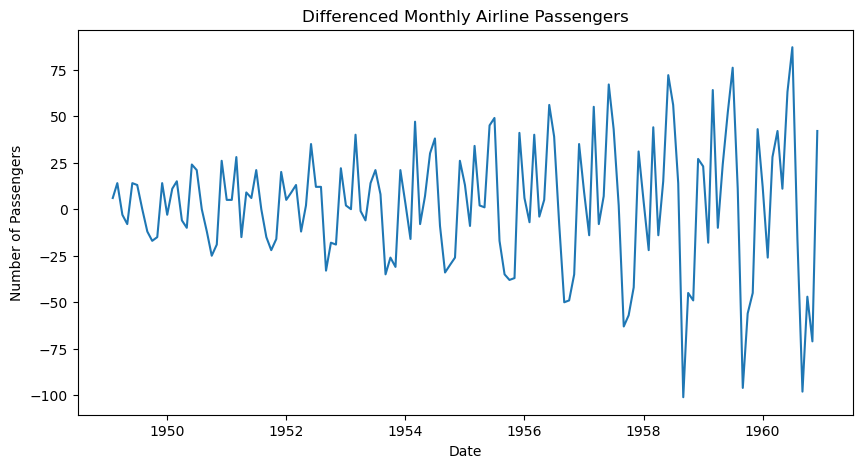

In [3]:
# Check for stationarity
result = adfuller(df['#Passengers'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If the p-value is > 0.05, the data is not stationary. We need to difference it.
if result[1] > 0.05:
    df_diff = df['#Passengers'].diff().dropna()

    # Check for stationarity again
    result = adfuller(df_diff)
    print('ADF Statistic after differencing:', result[0])
    print('p-value after differencing:', result[1])

    # Plot the differenced data
    plt.figure(figsize=(10, 5))
    plt.plot(df_diff)
    plt.title('Differenced Monthly Airline Passengers')
    plt.xlabel('Date')
    plt.ylabel('Number of Passengers')
    plt.show()
else:
    df_diff = df['#Passengers']


In [4]:
# Split the data into training and testing sets
train_size = int(0.8 * len(df_diff))
train_data = df_diff[:train_size]
test_data = df_diff[train_size:]


In [14]:
# Fit the SARIMA model on the training data
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Print the model summary
print(model_fit.summary())


C:\Users\71591\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\71591\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -374.184
Date:                            Tue, 23 Jul 2024   AIC                            758.368
Time:                                    14:17:17   BIC                            771.444
Sample:                                02-01-1949   HQIC                           763.661
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1825      0.098     -1.863      0.062      -0.375       0.009
ma.L1         -0.9999     10.194   

In [15]:
# Make predictions on the test set
start = len(train_data)
end = len(df_diff) - 1
predictions = model_fit.predict(start=start, end=end, dynamic=False)

# Align the index of the predictions with the test data
predictions = pd.Series(predictions, index=test_data.index)


In [16]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared
r2 = r2_score(test_data, predictions)

# Print the evaluation metrics
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {r2:.2f}')


Mean Squared Error: 426.45
Root Mean Squared Error: 20.65
R-squared: 0.84


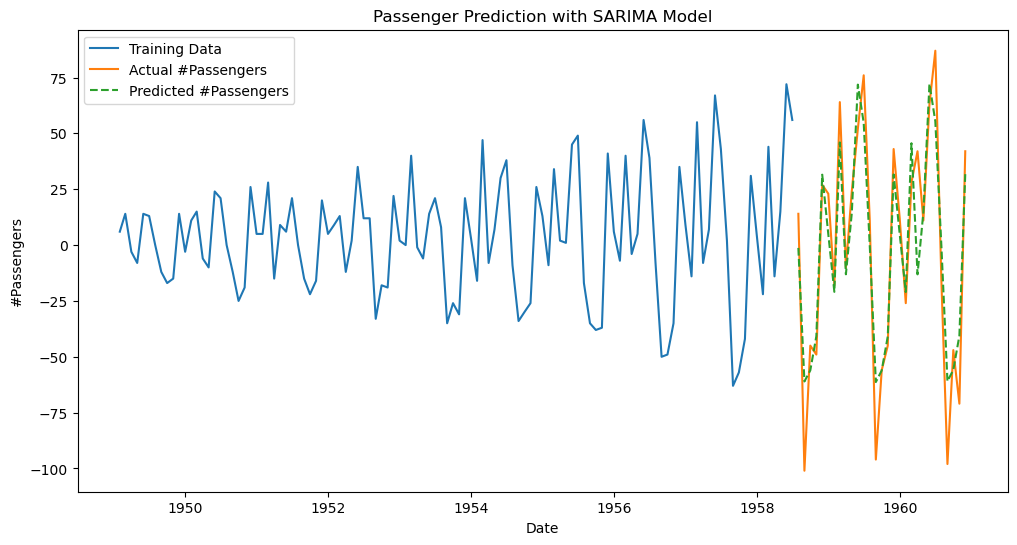

In [17]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual #Passengers')
plt.plot(test_data.index, predictions, label='Predicted #Passengers', linestyle='--')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.legend()
plt.title('Passenger Prediction with SARIMA Model')
plt.show()
